# Imports 

In [4]:
import numpy as np
import pandas as pd
from collections import Counter  

#Importing essential libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix               
from imblearn.under_sampling import RandomUnderSampler
#Importing essential libraries
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score


# Data processing

## Data loading and preprocessing

In [ ]:
raw_data= pd.read_csv('/Users/ceciliaacosta/IFT-6390-ml_fundamentals/classification-of-extreme-weather-events-udem/train.csv')
raw_data.shape

# training data
df=raw_data.drop(['SNo'], axis=1)

# drop duplicates
df=df.drop_duplicates()
# Calculate the mean and standard deviation for rows where 'Label' == 0

# Empty list to hold dataframes after filtering outliers for each label
dfs = []

# Loop through each unique label
for label in df['Label'].unique():
    
    # Split the data based on current label
    label_df = df[df['Label'] == label]
    
    # Compute upper and lower limits using only current label data
    mean_vals = label_df.mean()
    std_vals = label_df.std()
    upper_lim = mean_vals + 3 * std_vals
    lower_lim = mean_vals - 3 * std_vals
    
    # Filter out the 'Label' column from label_df for comparison
    
    filtered_label_df = label_df[label_df.columns.difference(['Label'])]

    # Create the mask using the limits
    mask = (filtered_label_df < upper_lim.reindex(filtered_label_df.columns)) & \
           (filtered_label_df > lower_lim.reindex(filtered_label_df.columns))
    
    # Apply the mask to label_df
    filtered_label_df = label_df[mask.all(axis=1)]

    # Append the filtered label dataframe to dfs list
    dfs.append(filtered_label_df)

# Concatenate all the filtered dataframes back together
df = pd.concat(dfs, axis=0)

df = df.reset_index(drop=True)

# shuffle
df = df.sample(frac=1).reset_index(drop=True)


- **Change 'time' column to datetime format**
- **Normalize the training data**

In [18]:
#change the column of time to make it cyclical with cos and sin functions  
from datetime import datetime   

#------------------  Prepare the test data  ---------------------------------------------------

test_data= pd.read_csv('/Users/ceciliaacosta/IFT-6390-ml_fundamentals/classification-of-extreme-weather-events-udem/test.csv')

# ------------------  Function to help modify the 'time column'  ------------------
def check_format(date_str):
    try:
        # Convert the date into a datetime object
        date_str =str(date_str)
        datetime.strptime(date_str, '%Y%m%d')
        return True 
    except ValueError:
        return False

final_pred=test_data['SNo']
test_data1=test_data.copy()
test_data1=pd.DataFrame(test_data1)
test_data1=test_data1.drop('SNo', axis=1)
#transform the time column  
test_data1['time'] = test_data1['time'].astype(str)
# Apply the function to get a mask of rows that match the format
mask = test_data1['time'].apply(check_format)
# Convert only the valid dates to datetime
test_data1.loc[mask, 'time'] = test_data1.loc[mask, 'time'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))
# Now, let's extract the day of year
test_data1['day_of_year'] = test_data1['time'].apply(lambda x: x.dayofyear if isinstance(x, datetime) else None)
#cyclical
days_in_year = 365.0

test_data1['day_of_year'].fillna(0, inplace=True)

test_data1['sin_day'] = np.sin(2 * np.pi * test_data1['day_of_year'] / days_in_year)
test_data1['cos_day'] = np.cos(2 * np.pi * test_data1['day_of_year'] / days_in_year)

test_data1=test_data1.drop(['time'], axis=1)
test_data1=test_data1.drop(['day_of_year'], axis=1)

# min max scaling of the test data
finaltest_data= test_data1-test_data1.min() / (test_data1.max()-test_data1.min())
finaltest_data['sin_day']=test_data1['sin_day']
finaltest_data['cos_day']=test_data1['cos_day']

# Apply the function to the 'date' column to get a boolean mask
df['time'] = df['time'].astype(str)
mask = df['time'].apply(check_format)

# Use the mask to transform only the dates with the right format
df.loc[mask, 'time'] = df.loc[mask, 'time'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))
# This step ensures that the entire 'time' column is treated as datetime, converting non-datetime entries to NaT
df['time'] = pd.to_datetime(df['time'], errors='coerce')
day_of_year = df['time'].dt.dayofyear

# Days in a year (considering non-leap years for simplicity)
days_in_year = 365.0
# Apply sin for cyclic encoding
df['sin_day'] = np.sin(2 * np.pi * day_of_year / days_in_year)
df['cos_day'] = np.cos(2 * np.pi * day_of_year / days_in_year)  


y=df['Label']
y=y.reset_index()
#transform y in a dataframe with one column from a series  
y=pd.DataFrame(y, columns=['Label'], index=y.index)

#create a one hot encoding for the labels of y without any library:
one_hot_y = np.zeros((y.shape[0], len(np.unique(y))))
for i in range(len(y)):
    one_hot_y[i, y['Label'].get(i)] = 1
Y=one_hot_y



# ------------------  Prepare the training data  ------------------
X=df.drop(['Label'], axis=1)
X=X.drop(['time'], axis=1)

#min max scaling
X= X-X.min() / (X.max()-X.min())  
X['sin_day']=df['sin_day']
X['cos_day']=df['cos_day']

print(X.shape)
print(Y.shape)
print(finaltest_data.shape)




Counter({0: 17099, 2: 4250, 1: 1033})
(22382, 20)
(22382, 3)
(10320, 20)


# Model XGBOOST: using only SMOTE

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.03, 'gamma': 0.15, 'colsample_bytree': 0.7}
Accuracy: 0.8521331248603976

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      3403
           1       0.77      0.49      0.60       207
           2       0.75      0.59      0.66       867

    accuracy                           0.85      4477
   macro avg       0.80      0.67      0.72      4477
weighted avg       0.85      0.85      0.84      4477



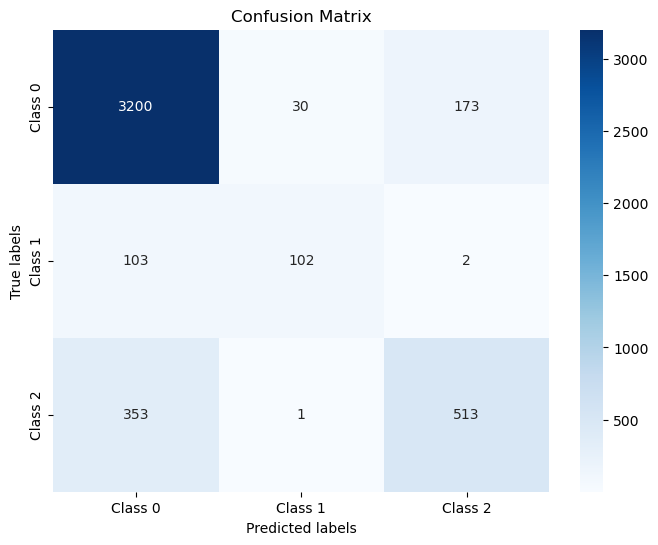

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Set up XGBoost classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)

# Define the hyperparameters and their possible values
param_distributions = {
    'learning_rate': [0.01, 0.03, 0.05, 0.08],
    'n_estimators': [50, 70, 100,130],
    'max_depth': [ 5,6, 7, 8],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'gamma': [0,0.15,0.25, 0.35, 0.40]
}

# Create the randomized search object
random_search = RandomizedSearchCV(clf, param_distributions=param_distributions, n_iter=50, 
                                   scoring='accuracy', cv=3, verbose=1, n_jobs=-1, random_state=42)

# Fit the random search object to the SMOTE-resampled training data
random_search.fit(X_train, y_train)

# Print best parameters from the random search
print("Best Parameters:", random_search.best_params_)

# Predict using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test) 

# Evaluate the predictions
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.03, 'gamma': 0.15, 'colsample_bytree': 0.7}
Accuracy: 0.8521331248603976

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      3403
           1       0.77      0.49      0.60       207
           2       0.75      0.59      0.66       867

    accuracy                           0.85      4477
   macro avg       0.80      0.67      0.72      4477
weighted avg       0.85      0.85      0.84      4477

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
Accuracy: 0.855036855036855

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      3403
           1       0.78      0.48      0.60       207
           2       0.74      0.62      0.68       867

    accuracy                           0.86      4477
   macro avg       0.80      0.68      0.73      4477
weighted avg       0.85      0.86      0.85      4477



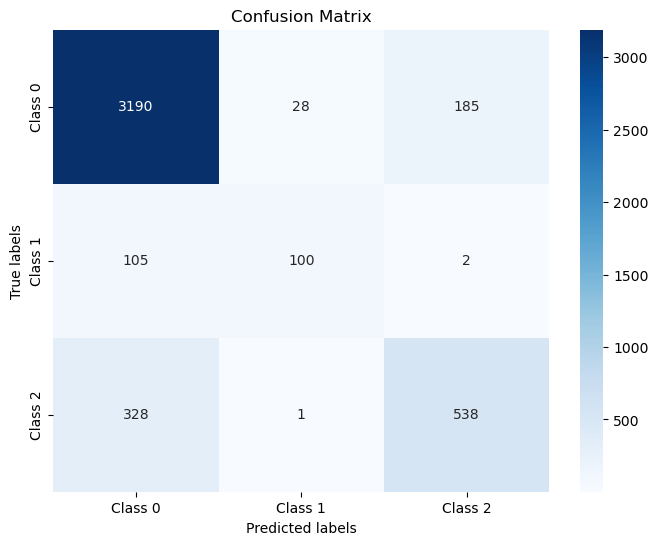

In [12]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42, sampling_strategy=0.3)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Set up XGBoost classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)

# Define the hyperparameters and their possible values
param_distributions = {
    'learning_rate': [0.01, 0.03, 0.05, 0.08],
    'n_estimators': [50, 70, 100,130],
    'max_depth': [ 5,6, 7, 8],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'gamma': [0,0.15,0.25, 0.35, 0.40]
}

# Create the randomized search object
random_search = RandomizedSearchCV(clf, param_distributions=param_distributions, n_iter=50, 
                                   scoring='accuracy', cv=3, verbose=1, n_jobs=-1, random_state=42)

# Fit the random search object to the SMOTE-resampled training data
random_search.fit(X_train, y_train)

# Print best parameters from the random search
print("Best Parameters:", random_search.best_params_)

# Predict using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test) 

# Evaluate the predictions
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# XGBOOST: SMOTETomeks model


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Accuracy: 0.8498994862631226

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      3393
           1       0.62      0.68      0.65       211
           2       0.68      0.76      0.72       873

    accuracy                           0.85      4477
   macro avg       0.74      0.77      0.75      4477
weighted avg       0.86      0.85      0.85      4477



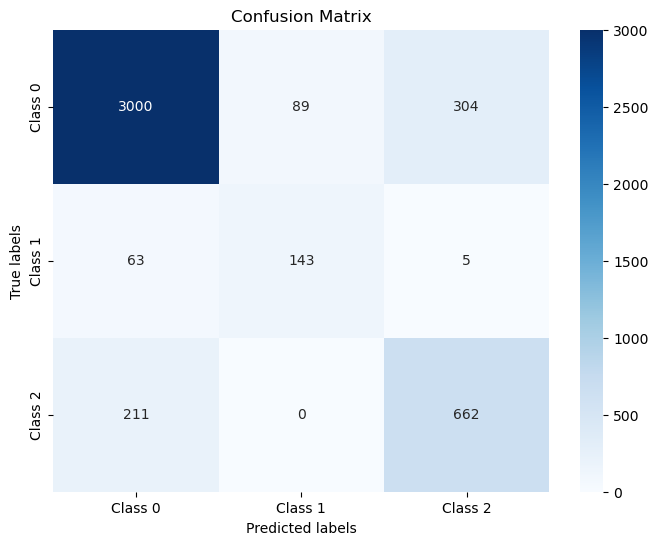

In [22]:
# Apply SMOTE + Tomek links
from imblearn.combine import SMOTETomek

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smt = SMOTETomek(random_state=42 , sampling_strategy={1: 2000, 2: 5000})
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

# Set up XGBoost classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)

# Define the hyperparameters and their possible values
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.25, 0.5, 1]
}

# Create the randomized search object
random_search = RandomizedSearchCV(clf, param_distributions=param_distributions, n_iter=50, 
                                   scoring='accuracy', cv=3, verbose=1, n_jobs=-1, random_state=42)

# Fit the random search object to the SMOTE-resampled training data
random_search.fit(X_resampled, y_resampled)

# Print best parameters from the random search
print("Best Parameters:", random_search.best_params_)

# Predict using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the predictions
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Predictions with XGBoost and SMOTETomek 

- Fits the model to the whole training set
- Predicts the test set
- Creates a submission file

In [23]:
# Apply SMOTE + Tomek links to the entire dataset
smt = SMOTETomek(random_state=42 , sampling_strategy={1: 2000, 2: 5000})
X_resampled, y_resampled = smt.fit_resample(X, y)

# Set up XGBoost classifier using the best parameters from the random search in the previous step
best_model.fit(X_resampled, y_resampled)    

# Predict using the best model
pred = best_model.predict(finaltest_data)

# Save predictions to submission file
final_pred=test_data['SNo']
pred1=pd.DataFrame(pred)

final_pred=pd.concat([final_pred, pred1], axis=1  )
final_pred.columns=['SNo', 'Label']
final_pred.to_csv('submission_tomek_smote.csv', index=False)

# Random forest with random undersampler

In [89]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Balancing the dataset using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Training a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_resampled)

# Predicting on the test set
y_pred = clf.predict(X_test)

# Evaluating the classifier

print("\nClassification Report:\n", classification_report(y_test, y_pred))

/Users/ceciliaacosta/miniconda3/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      5096
           1       0.60      0.54      0.57       321
           2       0.62      0.61      0.62      1298

    accuracy                           0.81      6715
   macro avg       0.70      0.68      0.69      6715
weighted avg       0.81      0.81      0.81      6715



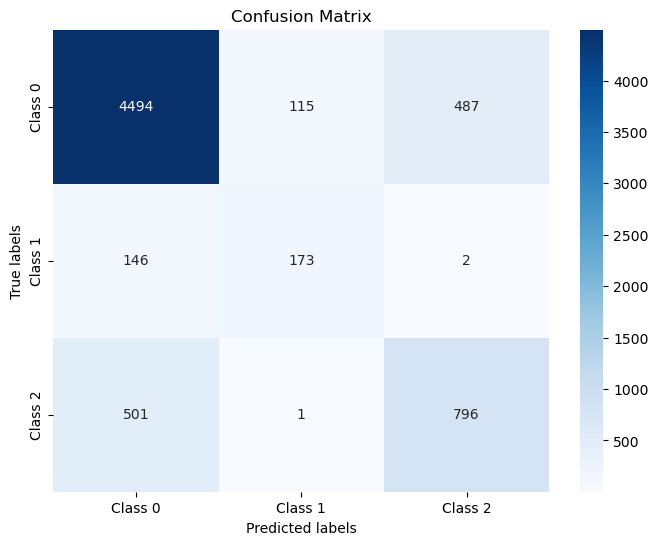

In [91]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()